In [1]:
import numpy as np

import tensorflow as tf
import keras.backend as K
from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
def round_through(x):
    '''Element-wise rounding to the closest integer with full gradient propagation.
    A trick from [Sergey Ioffe](http://stackoverflow.com/a/36480182)
    '''
    rounded = K.round(x)
    return x + K.stop_gradient(rounded - x)


def _hard_sigmoid(x):
    '''Hard sigmoid different from the more conventional form (see definition of K.hard_sigmoid).

    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}

    '''
    x = (0.5 * x) + 0.5
    return K.clip(x, 0, 1)


def binary_sigmoid(x):
    '''Binary hard sigmoid for training binarized neural network.

    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}

    '''
    return round_through(_hard_sigmoid(x))


def binary_tanh(x):
    '''Binary hard sigmoid for training binarized neural network.
     The neurons' and weights' activations binarization function
     It behaves like the sign function during forward propagation
     And like:
        hard_tanh(x) = 2 * _hard_sigmoid(x) - 1 
        clear gradient when |x| > 1 during back propagation

    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}

    '''
    return 2 * round_through(_hard_sigmoid(x)) - 1

In [0]:
from keras.layers import Dense, Conv2D
from keras import constraints
from keras import initializers


'''Binarized Dense and Convolution2D layers
References: 
"BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1" [http://arxiv.org/abs/1602.02830]
'''


class Clip(constraints.Constraint):

    def __call__(self, p):
        return K.clip(p, -1., 1.)


class BinaryDense(Dense):

    def __init__(self, units, **kwargs):
        super(BinaryDense, self).__init__(units, use_bias=False, 
                                          kernel_initializer=initializers.RandomUniform(-1., 1.),
                                          kernel_constraint=Clip(), **kwargs)


    def call(self, inputs):
        
        # 1. Binarize weights
        binary_kernel = binary_tanh(self.kernel)
        
        # 2. Perform matrix multiplication
        output = K.dot(inputs, binary_kernel)
        return output


class BinaryConv2D(Conv2D):

    def __init__(self, filters, kernel_size, **kwargs):
        super(BinaryConv2D, self).__init__(filters, kernel_size, use_bias=False, padding='same',
                                           kernel_initializer=initializers.RandomUniform(-1., 1.),
                                           kernel_constraint=Clip(), **kwargs)
        
    def call(self, inputs):
        
        # 1. Binarize weights
        binary_kernel = binary_tanh(self.kernel)
        
        if self.padding == 'same':
            # ones padding instead of zero padding (to keep the whole network real binary)
            kh = self.kernel_size // 2 if type(self.kernel_size) == int else self.kernel_size[0] // 2
            inputs = tf.pad(inputs, [[0,0], [kh, kh], [kh, kh], [0,0]], constant_values=1.)
        
        # 2. Perform convolution
        outputs = K.conv2d(
            inputs,
            binary_kernel,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
        
        return outputs

In [0]:
epochs = 20
# learning rate schedule
lr_start = 1e-3
lr_end = 1e-4
lr_decay = (lr_end / lr_start)**(1. / epochs)

# BN
epsilon = 1e-6  # default 1e-3
momentum = 0.9  # default 0.99

In [5]:
# the data, shuffled and split between train and test sets
dataset = 'mnist'
train = 'softmax'


if dataset == 'mnist':
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(60000, 28, 28, 1)
    X_test = X_test.reshape(10000, 28, 28, 1)
elif dataset == 'cifar10':
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
classes = y_train.max() + 1

if train == 'hinge':
    Y_train = np_utils.to_categorical(y_train, classes) * 2 - 1 # -1 or 1 for hinge loss
    Y_test = np_utils.to_categorical(y_test, classes) * 2 - 1
elif train == 'softmax':
    Y_train = Y_train = np_utils.to_categorical(y_train, classes)
    Y_test = np_utils.to_categorical(y_test, classes)

60000 train samples
10000 test samples


In [0]:
model = Sequential()


# conv1
model.add(BinaryConv2D(32, (3,3), name='conv1', input_shape=X_train.shape[1:]))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn1'))
model.add(Activation(binary_tanh, name='act1'))
# conv2
model.add(BinaryConv2D(32, (3,3), name='conv2'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn2'))
model.add(Activation(binary_tanh, name='act2'))

model.add(MaxPooling2D(name='pool2'))

# conv3
model.add(BinaryConv2D(64, (3,3), name='conv3'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn3'))
model.add(Activation(binary_tanh, name='act3'))
# conv4
model.add(BinaryConv2D(64, (3,3), name='conv4'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn4'))
model.add(Activation(binary_tanh, name='act4'))

model.add(MaxPooling2D(name='pool4'))

model.add(Flatten())
# dense1
model.add(BinaryDense(128, name='dense5'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn5'))
model.add(Activation(binary_tanh, name='act5'))
# dense2
model.add(BinaryDense(classes, name='dense6'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn6'))

if train =='softmax':
    model.add(Activation('softmax'))

In [7]:
opt = Adam(lr=lr_start)

if train == 'softmax':
    loss = 'categorical_crossentropy'
elif train == 'hinge':
    loss = 'squared_hinge'

model.compile(loss=loss, optimizer=opt, metrics=['acc'])
model.summary()

lr_scheduler = LearningRateScheduler(lambda e: lr_start * lr_decay ** e)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (BinaryConv2D)         (None, 28, 28, 32)        288       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 28, 28, 32)        128       
_________________________________________________________________
act1 (Activation)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2 (BinaryConv2D)         (None, 28, 28, 32)        9216      
_________________________________________________________________
bn2 (BatchNormalization)     (None, 28, 28, 32)        128       
_________________________________________________________________
act2 (Activation)            (None, 28, 28, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 32)        0         
__________

In [8]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    batch_size=256, epochs=epochs,
                    callbacks=[lr_scheduler])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 23s 383us/step - loss: 1.4256 - acc: 0.5716 - val_loss: 0.9220 - val_acc: 0.7818
Epoch 2/20
59392/60000 [============================>.] - ETA: 0s - loss: 0.7796 - acc: 0.8192

60000/60000 [==============================] - 21s 342us/step - loss: 0.7783 - acc: 0.8195 - val_loss: 0.6467 - val_acc: 0.8608
Epoch 3/20
60000/60000 [==============================] - 21s 342us/step - loss: 0.5820 - acc: 0.8686 - val_loss: 0.5395 - val_acc: 0.8815
Epoch 4/20
33280/60000 [===============>..............] - ETA: 8s - loss: 0.4842 - acc: 0.8893

60000/60000 [==============================] - 21s 343us/step - loss: 0.4608 - acc: 0.8956 - val_loss: 0.4062 - val_acc: 0.9123
Epoch 5/20
60000/60000 [==============================] - 21s 342us/step - loss: 0.3909 - acc: 0.9109 - val_loss: 0.3673 - val_acc: 0.9209
Epoch 6/20
27392/60000 [============>.................] - ETA: 10s - loss: 0.3479 - acc: 0.9225

60000/60000 [==============================] - 21s 342us/step - loss: 0.3386 - acc: 0.9231 - val_loss: 0.3249 - val_acc: 0.9301
Epoch 7/20
60000/60000 [==============================] - 21s 343us/step - loss: 0.2988 - acc: 0.9320 - val_loss: 0.2857 - val_acc: 0.9323
Epoch 8/20
25856/60000 [===========>..................] - ETA: 11s - loss: 0.2753 - acc: 0.9378

60000/60000 [==============================] - 21s 342us/step - loss: 0.2703 - acc: 0.9380 - val_loss: 0.2653 - val_acc: 0.9398
Epoch 9/20
60000/60000 [==============================] - 21s 342us/step - loss: 0.2458 - acc: 0.9431 - val_loss: 0.2435 - val_acc: 0.9443
Epoch 10/20
25600/60000 [===========>..................] - ETA: 11s - loss: 0.2406 - acc: 0.9427

60000/60000 [==============================] - 21s 343us/step - loss: 0.2335 - acc: 0.9445 - val_loss: 0.2591 - val_acc: 0.9432
Epoch 11/20
60000/60000 [==============================] - 21s 342us/step - loss: 0.2227 - acc: 0.9474 - val_loss: 0.2475 - val_acc: 0.9437
Epoch 12/20
25344/60000 [===========>..................] - ETA: 11s - loss: 0.2102 - acc: 0.9493

60000/60000 [==============================] - 21s 343us/step - loss: 0.2076 - acc: 0.9497 - val_loss: 0.2717 - val_acc: 0.9407
Epoch 13/20
60000/60000 [==============================] - 21s 343us/step - loss: 0.1973 - acc: 0.9529 - val_loss: 0.2911 - val_acc: 0.9324
Epoch 14/20
25088/60000 [===========>..................] - ETA: 11s - loss: 0.1910 - acc: 0.9550

60000/60000 [==============================] - 21s 343us/step - loss: 0.1897 - acc: 0.9539 - val_loss: 0.1927 - val_acc: 0.9550
Epoch 15/20
60000/60000 [==============================] - 21s 343us/step - loss: 0.1847 - acc: 0.9535 - val_loss: 0.2066 - val_acc: 0.9519
Epoch 16/20
25088/60000 [===========>..................] - ETA: 11s - loss: 0.1833 - acc: 0.9552

60000/60000 [==============================] - 21s 342us/step - loss: 0.1777 - acc: 0.9564 - val_loss: 0.2257 - val_acc: 0.9480
Epoch 17/20
60000/60000 [==============================] - 20s 341us/step - loss: 0.1743 - acc: 0.9567 - val_loss: 0.1995 - val_acc: 0.9541
Epoch 18/20
25088/60000 [===========>..................] - ETA: 11s - loss: 0.1694 - acc: 0.9592

60000/60000 [==============================] - 21s 342us/step - loss: 0.1679 - acc: 0.9597 - val_loss: 0.1825 - val_acc: 0.9574
Epoch 19/20
60000/60000 [==============================] - 21s 342us/step - loss: 0.1656 - acc: 0.9588 - val_loss: 0.1868 - val_acc: 0.9560
Epoch 20/20
25088/60000 [===========>..................] - ETA: 11s - loss: 0.1635 - acc: 0.9584

60000/60000 [==============================] - 21s 343us/step - loss: 0.1641 - acc: 0.9586 - val_loss: 0.1651 - val_acc: 0.9603


[]

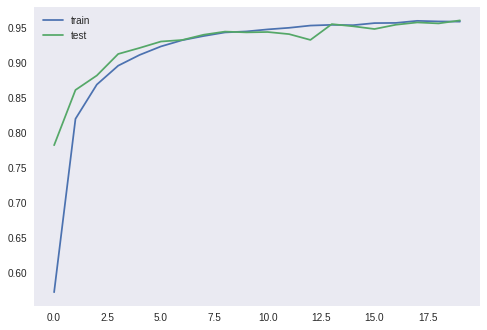

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.grid()
plt.legend()
plt.plot()